<a href="https://colab.research.google.com/github/raul-rufato/smt/blob/newsmt/tutorial/SMT_MixedInteger_application.ipynb" target="_blank" rel="nofollow"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>

# Multi-fidelity Kriging (MFK) with noisy observations

Andrés F. LOPEZ-LOPERA ONERA/DTIS/M2CI - Juin 2021

May 2023 version 2.0

<p class="alert alert-success" style="padding:1em">
To use SMT models, please follow this link: https://github.com/SMTorg/SMT/blob/master/README.md. The documentation is available here: http://smt.readthedocs.io/en/latest/
</p>


**Reference paper:** https://www.sciencedirect.com/science/article/pii/S0965997818309360?via%3Dihub 

**Preprint:** https://www.researchgate.net/profile/Mohamed_Amine_Bouhlel/publication/331976718_A_Python_surrogate_modeling_framework_with_derivatives/links/5cc3cebd299bf12097829631/A-Python-surrogate-modeling-framework-with-derivatives.pdf

Cite us:

M.-A. Bouhlel, J. T. Hwang, N. Bartoli, R. Lafage, J. Morlier, J .R.R.A Martins (2019), A Python surrogate modeling framework with derivatives, Advances in Engineering Software, 102662


In [1]:
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [8, 5]

from smt.applications import MFK

#to ingnore warning messages
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

# 1. Problem statement

In this notebook, we focus on surrogate multi-fidelity Kriging models accouting for a noise term. Here we focus on a multi-fidelity GP framework with two levels of fidelity. The extension to more than two levels of fidelity can be obtained recursively as it is shown by Le Gratiet (2013). We denote $Y_{h}$ and $Y_{l}$ as the processes GPs related to the high and low-fidelity, respectively. To account for additive input-varying noisy observations, we can consider the system given by

\begin{align}
	Y_l^{\text{noise}}(x_i) &= Y_{l}(x_i) + \varepsilon_{l,i},
	\label{eq:MFsurrogateHeteroNoiseLF}	\\
	Y_h^{\text{noise}}(x_j) &= \rho(x_j) Y_{l}(x_j) + \nu(x_j) + \varepsilon_{h,j},
	\label{eq:MFsurrogateHeteroNoise}
\end{align}

where $\rho: \mathcal{D} \to \mathbb{R}$ is a scale factor between $Y_{l}$ and $Y_{h}$, and $\nu: \mathcal{D} \to \mathbb{R}$ the discrepancy function tasked with capturing the differences between both fidelity levels beyond scaling. We assume that $Y_l$ and $\nu$ are independent centred GP with covariance functions $k_l$ and $k_\nu$. For the additive Gaussian noise terms $\varepsilon_{l,1}, \ldots, \varepsilon_{l,n_l}$, $\varepsilon_{h,1}, \ldots, \varepsilon_{h,n_h}$, we assume that they are independent, and independent of $Y_l$ and $\nu$. This means that the covariance matrix $\Omega_l$ and $\Omega_h$ are given by:

$$\Omega_l = \begin{bmatrix} \tau_{l,1}^2 & \ldots & 0 \\ \vdots & \ddots & \vdots \\ 0 & \ldots & \tau_{l,n_l}^2 \end{bmatrix}, \qquad \Omega_h = \begin{bmatrix} \tau_{h,1}^2 & \ldots & 0 \\ \vdots & \ddots & \vdots \\ 0 & \ldots & \tau_{h,n_h}^2 \end{bmatrix},$$

with noise variances $\tau_{l,1}^2, \ldots, \tau_{l, n_l}^2, \tau_{h,1}^2, \ldots, \tau_{h, n_h}^2 \in \mathbb{R}^+$. Then, due to the linearity, $Y_l^{\text{noise}}$ and $Y_h^{\text{noise}}$ are also centred GP-distributed with covariance functions given by

\begin{align}
    \widetilde{k}_{l}(x, x') &= {k}_{l}(x, x') + \tau_{l,x}^2 \delta_{x}(x'),	\label{eq:MFsurrogateHeteroNoiseLFkernel} \\
    \widetilde{k}_{h}(x, x') &= \rho(x) \rho(x') {k}_{l}(x, x') + k_{\nu}(x, x') + \tau_{h,x}^2 \delta_{x}(x'),
\end{align} 

where $\delta_{x}(x')$ is the Dirac delta function that is equal to one if $x = x'$, and zero otherwise. Then, since $Y_l^{\text{noise}}$ and $Y_h^{\text{noise}}$ are GP-distributed, one can establish the conditional formulas for computing the Gaussian distribution

$$Y_{h}|\{Y_{l}(x_{l,1}) + \varepsilon_{l,1} = y_{l, 1}, \ldots, Y_{l}(x_{l,n_{l}})  + \varepsilon_{l,n_l} = y_{l, n_{l}}, Y_{h}(x_{h,1})  + \varepsilon_{h,1} = y_{h, 1}, \ldots, Y_{h}(x_{h,n_{h}}) + \varepsilon_{h,n_h} = y_{h, n_{h}} \},$$

with observations $y_{l, 1}, \ldots, y_{l, n_l}$ (low-fidelity) and $y_{h, 1}, \ldots, y_{h, n_h}$ (high-fidelity). Those formulas follow the same structure as the ones for the noise-free case but replacing ${k}_{l}(x, x')$ to $\widetilde{k}_{l}(x, x')$ and ${k}_{h}(x, x')$ to $\widetilde{k}_{h}(x, x')$.

Two cases can be considered:

- **Homoscedastic (default) case:** the noise variances are considered to be equal, i.e.: $\tau^2 = \tau_1^2 = \cdots = \tau_n^2$. The value of $\tau^2$ can be estimated via maximum likelihood.
- **Heterocedastic case:** the noise variances vary across the observations, i.e.: $\tau_1^2 \ne \cdots \ne \tau_n^2$. Those variances can only be estimated if repetitions of observations are given. Developments here are based on pointwise sensible estimates [1] and on the implementations in [2].

In the following, we focus on the heteroscedastic case. We refer to the notebook ``SMT_Noise.ipynb`` for an example of the single-fidelity case.µ

**References**

[1] Loic Le Gratiet (2013). "Multi-Fidelity Gaussian Process Regression for Computer Experiments." Theses, Université Paris-Diderot - Paris VII. <br/>
[2] Bruce Ankenman, Barry L. Nelson and Jeremy Staum (2010). "Stochastic Kriging for Simulation Metamodeling." Operations Research. Vol. 58, No. 2 , pp. 371-382.  <br/> 
[3] Olivier Roustant, David Ginsbourger and Yves Deville (2012). "DiceKriging, DiceOptim: Two R Packages for the analysis of computer experiments by kriging-based metamodeling and optimization." Journal of Statistical Software, Vol. 51, No. 1, pp. 1-55.


## Toy data

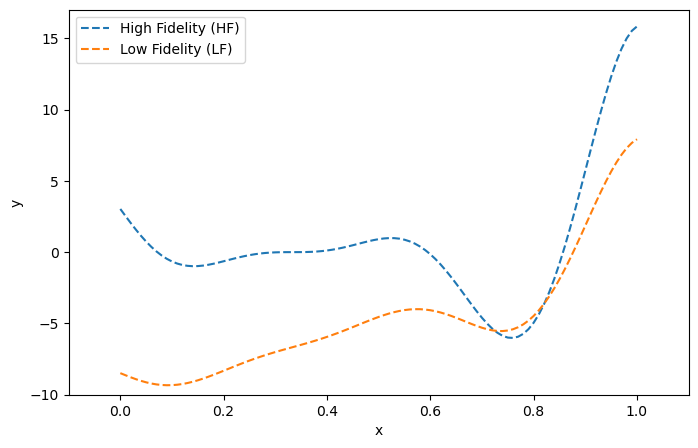

In [2]:
def LF_function(x): # low-fidelity function
    return 0.5*((x*6-2)**2)*np.sin((x*6-2)*2)+(x-0.5)*10. - 5

def HF_function(x): # high-fidelity function
    return ((x*6-2)**2)*np.sin((x*6-2)*2)

x = np.linspace(0, 1, 101, endpoint=True).reshape(-1, 1)

plt.figure()
plt.plot(x, HF_function(x), '--C0', label='High Fidelity (HF)')
plt.plot(x, LF_function(x), '--C1', label='Low Fidelity (LF)')
plt.ylim(-10, 17); plt.xlim(-0.1, 1.1)
plt.xlabel('x'); plt.ylabel('y')
plt.legend();

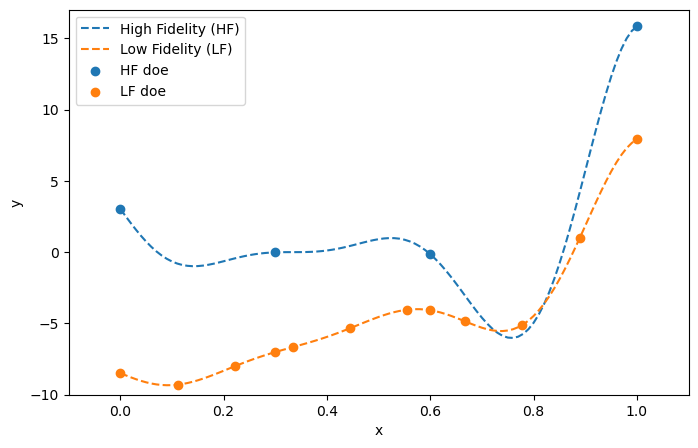

In [3]:
#Expensive DOE with 4 points
Xt_e = np.array([0.0, 0.3, 0.6, 1.]).reshape(-1, 1)
#Cheap DOE with 12 points
Xt_c = np.linspace(1/9, 8/9, 8, endpoint=True).reshape(-1, 1)
# The two DOEs must be nest: Xt_e must be included within Xt_c
Xt_c = np.concatenate((Xt_c,Xt_e),axis=0)

# Evaluate the HF and LF functions
yt_e = HF_function(Xt_e)
yt_c = LF_function(Xt_c)

plt.figure()
plt.plot(x, HF_function(x), '--C0', label='High Fidelity (HF)')
plt.plot(x, LF_function(x), '--C1', label='Low Fidelity (LF)')
plt.scatter(Xt_e, yt_e, color='C0', label='HF doe')
plt.scatter(Xt_c, yt_c, color='C1', label='LF doe')
plt.ylim(-10, 17); plt.xlim(-0.1, 1.1)
plt.xlabel('x'); plt.ylabel('y')
plt.legend();

## MFK with given noise variance parameters

In [4]:
# %% Build the MFK object
yt_joint = np.concatenate((yt_c, yt_e))
noise0 = [np.array([2e-01, 7e-02, 2e-03, 6e-08,
                    5e-02, 5e-02, 4e-02, 3e-02,
                    2e-01, 1e-02, 5e-06, 1e-01])/2,
          np.array([1.5, 0.4, 0.01, 0.1])/5]
theta0 = np.array([[0.5],[0.1]])
np.random.seed(7)
sm = MFK(theta0=theta0, theta_bounds = [1e-1, 20],
         noise0=noise0, use_het_noise = True,
         propagate_uncertainty=False, n_start=1)

# low-fidelity dataset names being integers from 0 to level-1
sm.set_training_values(Xt_c, yt_c, name=0)
# high-fidelity dataset without name
sm.set_training_values(Xt_e, yt_e)
# train the model
sm.train()

# test training
ntest = 101
nlvl = len(sm.X)
x = np.linspace(0, 1, ntest, endpoint=True).reshape(-1, 1)
# HF
y = sm.predict_values(x)
var = sm.predict_variances(x)
# LF
y0 = sm._predict_intermediate_values(x, 1)
var0, _ =  sm.predict_variances_all_levels(x)
var0 = var0[:,0].reshape(-1,1)

___________________________________________________________________________
   
                                    MFK
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 4
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  2.0887768
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 101
   
   Predicting ...
   Predicting - done. Time (sec):  0.0007741
   
   Prediction time/pt. (sec) :  0.0000077
   


In [5]:
# creating a single-fidelity GP model to compare with
theta0 = sm.options["theta0"]
noise0 = sm.options["noise0"]

# %% Kriging on monofidelity HF doe
sm_monoHF =  MFK(theta0=theta0[1].tolist(), theta_bounds = [1e-1, 20],
                 noise0=[noise0[1]], use_het_noise=True, n_start=1)

# %% Kriging on monofidelity LF Doe
sm_monoLF =  MFK(theta0=theta0[0].tolist(), theta_bounds = [1e-1, 20],
                 noise0=[noise0[0]], use_het_noise=True, n_start=1)

# train the model
sm_monoHF.set_training_values(Xt_e, yt_e)
sm_monoHF.train()

sm_monoLF.set_training_values(Xt_c, yt_c)
sm_monoLF.train()

# test training
y_monoHF = sm_monoHF.predict_values(x)
var_monoHF = sm_monoHF.predict_variances(x)

y_monoLF = sm_monoLF.predict_values(x)
var_monoLF = sm_monoLF.predict_variances(x)

___________________________________________________________________________
   
                                    MFK
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 4
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  0.0253081
___________________________________________________________________________
   
                                    MFK
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 12
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  0.0366437
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 101
   
   Predicting ...
   Predicting - done. Time (sec)

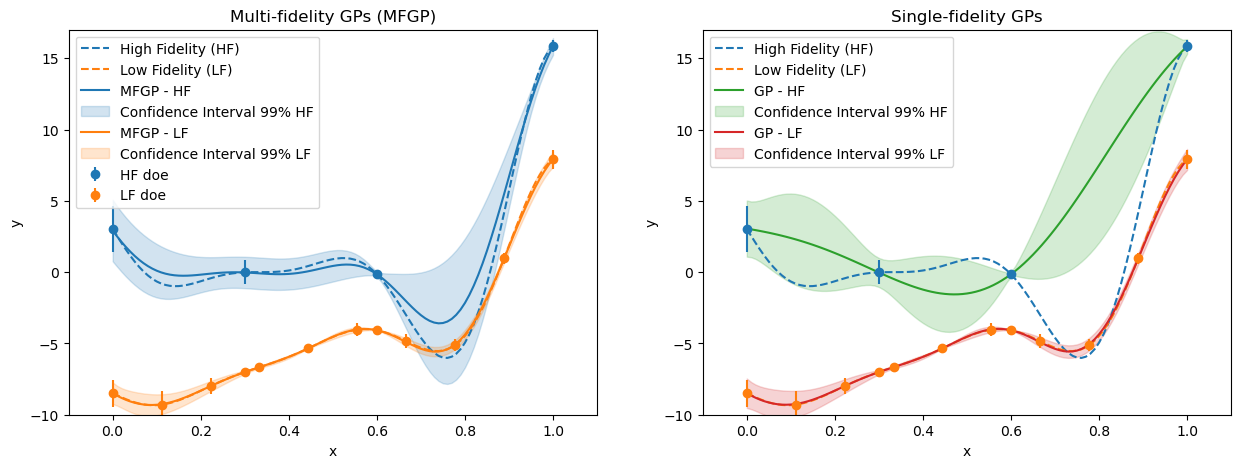

In [6]:
plt.figure(figsize = (15, 5))
plt.subplot(1,2,1)
plt.plot(x, HF_function(x), '--C0', label='High Fidelity (HF)')
plt.plot(x, LF_function(x), '--C1', label='Low Fidelity (LF)')
plt.plot(x, y, 'C0', label='MFGP - HF')
plt.fill_between(np.ravel(x), np.ravel(y-3*np.sqrt(var)),
                  np.ravel(y+3*np.sqrt(var)),
                  color='C0',alpha=0.2, label ='Confidence Interval 99% HF')
plt.plot(x, y0, 'C1', label='MFGP - LF')
plt.fill_between(np.ravel(x), np.ravel(y0-3*np.sqrt(var0)),
                  np.ravel(y0+3*np.sqrt(var0)),
                  color='C1',alpha=0.2, label ='Confidence Interval 99% LF')

plt.errorbar(np.squeeze(Xt_e), np.squeeze(yt_e), yerr=np.squeeze(3*np.sqrt(noise0[-1])),
             fmt="o", color="C0", label='HF doe')
plt.errorbar(np.squeeze(Xt_c), np.squeeze(yt_c), yerr=np.squeeze(3*np.sqrt(noise0[0])),
             fmt="o", color="C1", label='LF doe')
plt.ylim(-10, 17); plt.xlim(-0.1, 1.1)
plt.xlabel('x'); plt.ylabel('y')
plt.legend()
plt.title('Multi-fidelity GPs (MFGP)')

plt.subplot(1,2,2)
plt.plot(x, HF_function(x), '--C0', label='High Fidelity (HF)')
plt.plot(x, LF_function(x), '--C1', label='Low Fidelity (LF)')
plt.plot(x, y_monoHF, 'C2', label='GP - HF')
plt.fill_between(np.ravel(x), np.ravel(y_monoHF-3*np.sqrt(var_monoHF)),
                  np.ravel(y_monoHF+3*np.sqrt(var_monoHF)),
                  color='C2',alpha=0.2, label ='Confidence Interval 99% HF')
plt.plot(x, y_monoLF, 'C3', label='GP - LF')
plt.fill_between(np.ravel(x), np.ravel(y_monoLF-3*np.sqrt(var_monoLF)),
                  np.ravel(y_monoLF+3*np.sqrt(var_monoLF)),
                  color='C3',alpha=0.2, label ='Confidence Interval 99% LF')
plt.errorbar(np.squeeze(Xt_e), np.squeeze(yt_e), yerr=np.squeeze(3*np.sqrt(noise0[-1])),
             fmt="o", color="C0")
plt.errorbar(np.squeeze(Xt_c), np.squeeze(yt_c), yerr=np.squeeze(3*np.sqrt(noise0[0])),
             fmt="o", color="C1")
plt.ylim(-10, 17); plt.xlim(-0.1, 1.1)
plt.xlabel('x'); plt.ylabel('y')
plt.title('Single-fidelity GPs')
plt.legend();

## MFK with repetitions of observations

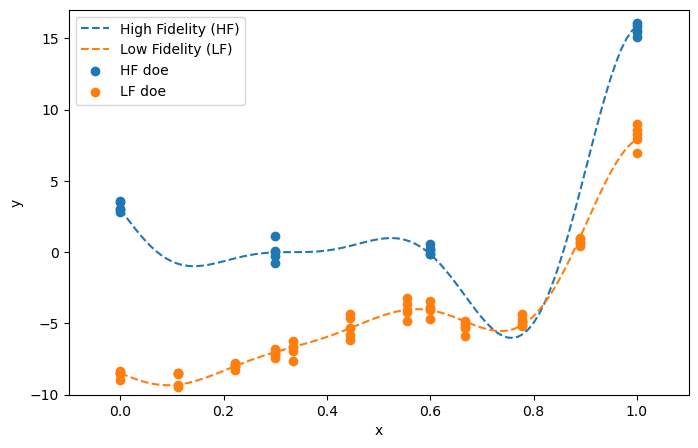

In [7]:
# adding noisy repetitions
Xt_c_reps = Xt_c.copy()
yt_c_reps = yt_c.copy()
Xt_e_reps = Xt_e.copy()
yt_e_reps = yt_e.copy()

for i in range(4):
    Xt_c_reps = np.concatenate((Xt_c_reps, Xt_c))
    Xt_e_reps = np.concatenate((Xt_e_reps, Xt_e))
    np.random.seed(i)
    yt_c_reps = np.concatenate((yt_c_reps,
                                yt_c + 0.1*np.std(yt_c)*np.random.normal(size=yt_c.shape)))
    yt_e_reps = np.concatenate((yt_e_reps,
                                yt_e + 0.1*np.std(yt_e)*np.random.normal(size=yt_e.shape)))

plt.figure()
plt.plot(x, HF_function(x), '--C0', label='High Fidelity (HF)')
plt.plot(x, LF_function(x), '--C1', label='Low Fidelity (LF)')
plt.scatter(Xt_e_reps, yt_e_reps, color='C0', label='HF doe')
plt.scatter(Xt_c_reps, yt_c_reps, color='C1', label='LF doe')
plt.ylim(-10, 17); plt.xlim(-0.1, 1.1)
plt.xlabel('x'); plt.ylabel('y')
plt.legend();

In [8]:
# %% Build the MFK object
yt_joint = np.concatenate((yt_c_reps, yt_e_reps))
theta0 = np.array([[0.5],[0.1]])
np.random.seed(7)
sm = MFK(theta0=theta0,
         noise0=noise0, eval_noise=True,
         use_het_noise = True,
         propagate_uncertainty = False, n_start=1)

# low-fidelity dataset names being integers from 0 to level-1
sm.set_training_values(Xt_c_reps, yt_c_reps, name=0)
# high-fidelity dataset without name
sm.set_training_values(Xt_e_reps, yt_e_reps)
# train the model
sm.train()

# test training
# HF
y = sm.predict_values(x)
var = sm.predict_variances(x)
# LF
y0 = sm._predict_intermediate_values(x, 1)
var0, _ =  sm.predict_variances_all_levels(x)
var0 = var0[:,0].reshape(-1,1)

___________________________________________________________________________
   
                                    MFK
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 20
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  0.0474021
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 101
   
   Predicting ...
   Predicting - done. Time (sec):  0.0000000
   
   Prediction time/pt. (sec) :  0.0000000
   


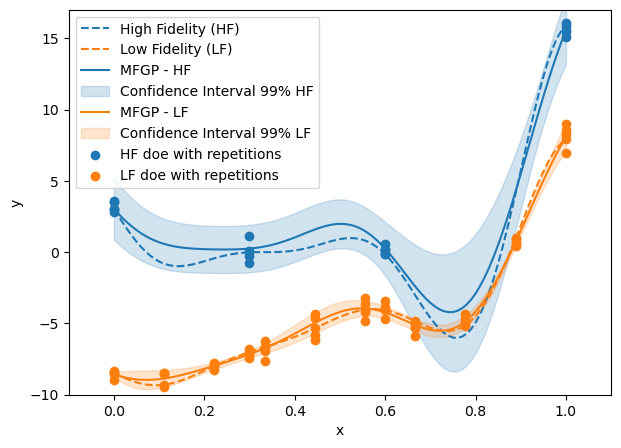

In [9]:
plt.figure(figsize=(7,5))
plt.plot(x, HF_function(x), '--C0', label='High Fidelity (HF)')
plt.plot(x, LF_function(x), '--C1', label='Low Fidelity (LF)')
plt.plot(x, y, 'C0', label='MFGP - HF')
plt.fill_between(np.ravel(x), np.ravel(y-3*np.sqrt(var)),
                 np.ravel(y+3*np.sqrt(var)),
                 color='C0',alpha=0.2 ,label ='Confidence Interval 99% HF')
plt.plot(x, y0, 'C1', label='MFGP - LF')
plt.fill_between(np.ravel(x), np.ravel(y0-3*np.sqrt(var0)),
                  np.ravel(y0+3*np.sqrt(var0)),
                  color='C1',alpha=0.2,label ='Confidence Interval 99% LF')
plt.scatter(Xt_e_reps, yt_e_reps, color='C0', label='HF doe with repetitions')
plt.scatter(Xt_c_reps, yt_c_reps, color='C1', label='LF doe with repetitions')
plt.xlabel('x'); plt.ylabel('y')
plt.ylim(-10, 17); plt.xlim(-0.1, 1.1)
plt.legend();